# House price prediction

The dataset for this project consists of property data from Melbourne.  
The features are a mix of continuous and categorical variables.  
The task is to predict which price class a property in the city belongs to.

### Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.pipeline      import make_pipeline
from sklearn.linear_model  import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [7]:
raw_df = pd.read_csv('data/train.csv', index_col=0)

### Data exploration and visualisation

Let's look at the shape of the data.

In [8]:
print(f'Shape of the dataset: {raw_df.shape}.')

Shape of the dataset: (11543, 15).


Let's have a look at the dataset.

In [9]:
raw_df.head()

,Rooms,Type,Method,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Regionname,Propertycount,Price class
0,4,h,S,6.4,3011.0,3.0,1.0,2.0,411.0,NaN,-37.79690,144.90490,Western Metropolitan,7570.0,1
1,4,h,S,14.6,3189.0,4.0,1.0,2.0,638.0,1972.0,-37.93780,145.05700,Southern Metropolitan,2555.0,1
2,5,h,PI,12.4,3107.0,5.0,4.0,2.0,968.0,1970.0,-37.77083,145.11516,Eastern Metropolitan,5420.0,1
3,3,h,SP,5.2,3056.0,3.0,1.0,2.0,264.0,NaN,-37.76110,144.96440,Northern Metropolitan,11918.0,0
4,3,h,S,8.8,3072.0,3.0,1.0,2.0,610.0,NaN,-37.75100,145.01970,Northern Metropolitan,14577.0,0


We see that the following features are strings: Type, Method and Regionname.  
We need to encode these features.

Let's check what types of data we have.

In [10]:
raw_df.dtypes

Rooms              int64
Type              object
Method            object
Distance         float64
Postcode         float64
Bedrooms         float64
Bathroom         float64
Car              float64
Landsize         float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
Price class        int64
dtype: object

Most of the features are floats.  
Number of rooms in a house is an integer.  
And the target feature is an integer.

Let's check for missing data.

In [11]:
raw_df.isna().sum()

Rooms               0
Type                0
Method              0
Distance            0
Postcode            0
Bedrooms            0
Bathroom           46
Car                53
Landsize           33
YearBuilt        4572
Lattitude           0
Longtitude          0
Regionname          0
Propertycount      40
Price class         0
dtype: int64

We see that we have missing data in the following features: Bathroom, Car, Landside, YearBuilt and Propertycount.  
This must be dealt with.

Let's see how many different categories we have in the target feature.

In [12]:
raw_df['Price class'].nunique()

3

The target feature has 3 different categories.  
Let's look at what those 3 labels are.

In [13]:
raw_df['Price class'].unique()

array([1, 0, 2], dtype=int64)

The three labels in the target are the following integers: 0, 1, and 2.

Lets look at the distribution of the target feature.

<AxesSubplot:>

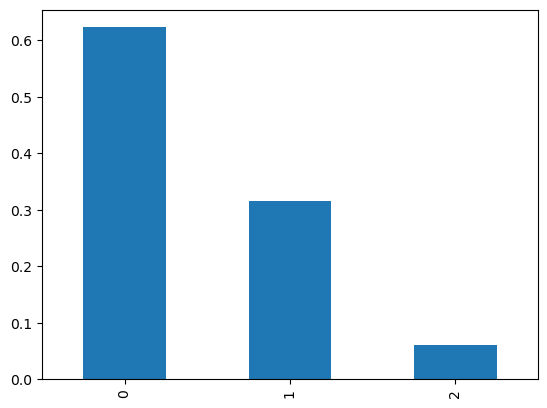

In [14]:
raw_df['Price class'].value_counts(normalize=True).plot(kind='bar')

We observe that the target feature is not very well balnced, so we should use macro f1 as the scoring metric.

### Data cleaning

First we will encode the features that are strings.

In [15]:
# We will use OneHotEncoder from scikitlearn to encode the string features.
def encoding(x):
    ohe = OneHotEncoder()
    ohe_results = ohe.fit_transform(raw_df[[x]])
    return pd.DataFrame(ohe_results.toarray(), columns=ohe.categories_[0])

# Type, Method and Regionname features need to be encoded
typ = encoding('Type')
method = encoding('Method')
region = encoding('Regionname')

# Add the encoded features
encoded_df = raw_df.join(pd.DataFrame(typ))
encoded_df = encoded_df.join(pd.DataFrame(method))
encoded_df = encoded_df.join(pd.DataFrame(region))

# Remove the original features containing strings
del encoded_df['Type']
del encoded_df['Method']
del encoded_df['Regionname']

Let's move price class, the target feature, to the end of the dataframe for convenience

In [16]:
price = encoded_df.pop('Price class')
encoded_df['Price class'] = price
encoded_df.head()

,Rooms,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,...,VB,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria,Price class
0,4,6.4,3011.0,3.0,1.0,2.0,411.0,NaN,-37.79690,144.90490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,4,14.6,3189.0,4.0,1.0,2.0,638.0,1972.0,-37.93780,145.05700,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,5,12.4,3107.0,5.0,4.0,2.0,968.0,1970.0,-37.77083,145.11516,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,3,5.2,3056.0,3.0,1.0,2.0,264.0,NaN,-37.76110,144.96440,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,3,8.8,3072.0,3.0,1.0,2.0,610.0,NaN,-37.75100,145.01970,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


Now we will deal with the missing data.  
First, we will try to remove the obervations with missing data.

In [17]:
nonan_df = encoded_df.dropna(axis=0)

In [18]:
lost_rows = encoded_df.shape[0] - nonan_df.shape[0]
print(f'Out of {raw_df.shape[0]} observations we lost {lost_rows} observations')

Out of 11543 observations we lost 4676 observations


Removing the observations with missing data caused us to lose almost half of the data, which is too much.  
We will try to replace the missing data with the mean value of the repective feature.

In [19]:
# We will use SimpleImputer scikitlearn to replace the missing data with mean values
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(encoded_df.values)
imputed_data = imr.transform(encoded_df.values)
imputed_df = pd.DataFrame(imr.fit_transform(encoded_df))
colnames = list(encoded_df.columns.values)
imputed_df = imputed_df.set_axis(colnames, axis=1, inplace=False)

Let's look at some basic statistics

In [20]:
imputed_df.describe()

,Rooms,Distance,Postcode,Bedrooms,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,...,VB,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria,Price class
count,11543.000000,11543.000000,11543.000000,11543.000000,11543.00000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,...,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000,11543.000000
mean,2.944122,10.158694,3105.288400,2.921164,1.53527,1.614534,531.192789,1964.764596,-37.809255,144.995236,...,0.088192,0.108637,0.003812,0.285541,0.003119,0.033440,0.345491,0.217448,0.002512,0.438794
std,0.953200,5.864749,90.169874,0.966528,0.69143,0.956776,1536.529369,29.099193,0.079379,0.104103,...,0.283586,0.311197,0.061625,0.451691,0.055761,0.179791,0.475549,0.412528,0.050062,0.607847
min,1.000000,0.000000,3000.000000,0.000000,0.00000,0.000000,0.000000,1196.000000,-38.182550,144.431810,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.200000,3044.000000,2.000000,1.00000,1.000000,180.000000,1960.000000,-37.857100,144.929500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,9.200000,3084.000000,3.000000,1.00000,2.000000,445.000000,1964.764596,-37.802300,145.000150,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,13.000000,3148.000000,3.000000,2.00000,2.000000,650.000000,1975.000000,-37.756250,145.058200,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,10.000000,48.100000,3977.000000,20.000000,8.00000,10.000000,76000.000000,2018.000000,-37.408530,145.526350,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


The standard deviation of Landsize is very large, about 3 times as large as the mean. Which is something we will have to deal with.

### Visualization

Let's make some visualisations to look at the distribution of the features.

First we will look at a histogram for the non-dummy features (including the dummies results in plots that are not very nice).

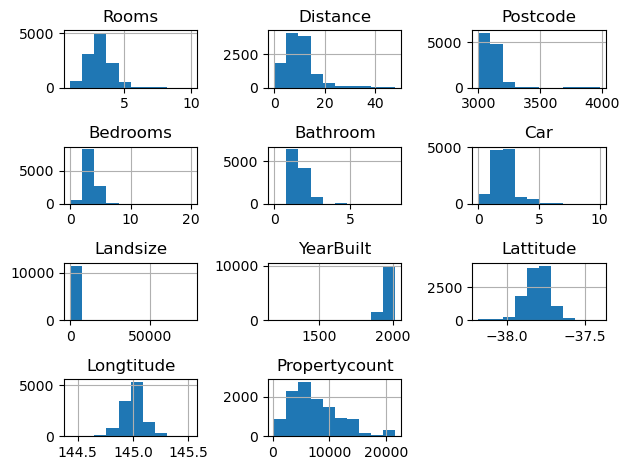

In [21]:
imputed_df.iloc[:,:11].hist()
plt.tight_layout()
plt.show()

Looks like there are some positive outliers in number of rooms, distance, postcode, bedrooms, bathrooms, car(parking spots), landsize and property count, while year built have some negative outliers

Let's make a violoin plot to have a closer look at the non-dummy features.

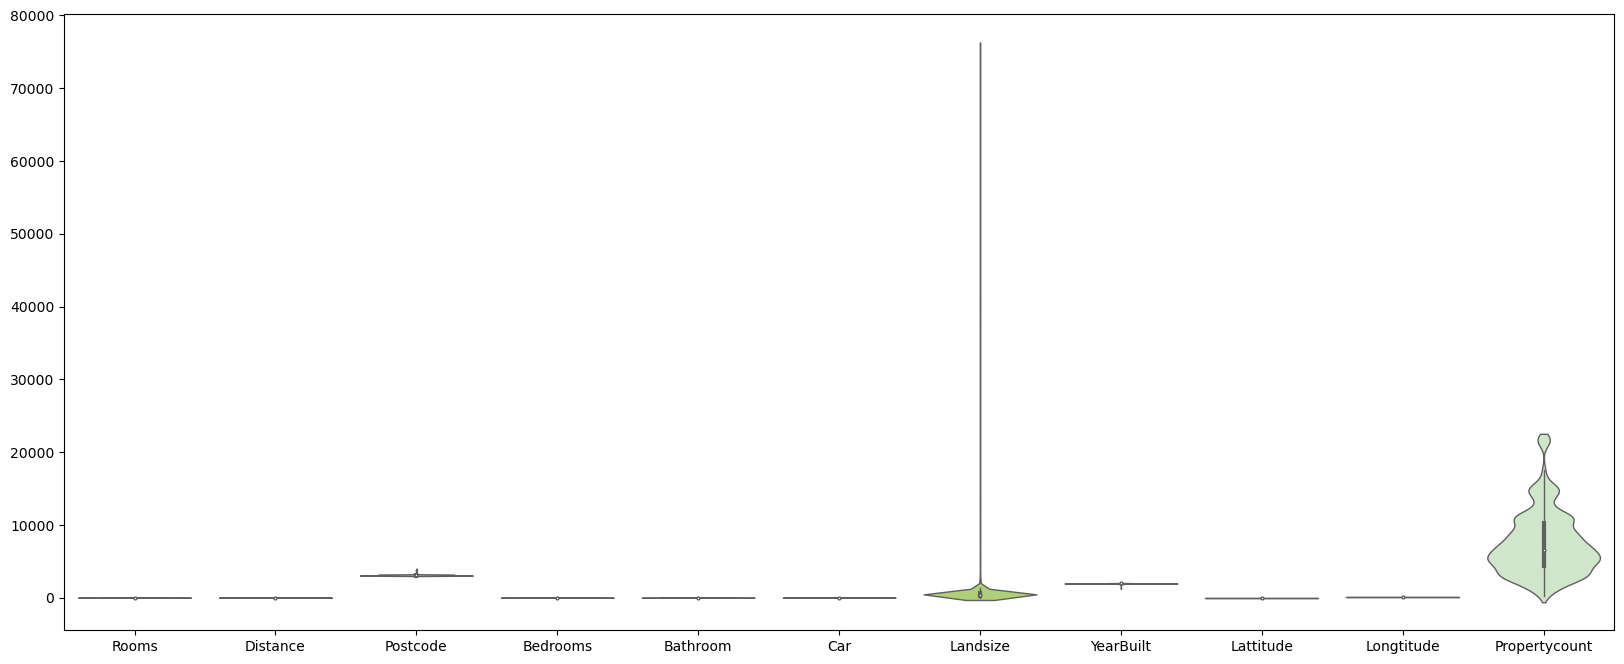

In [22]:
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=imputed_df.iloc[:,:11], palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

The positive outliers in Landsize are very large.  
Let's remove Landsize and Propertycount to better see the distribution of the other features.

In [23]:
imputed_df.iloc[:,:11].columns

Index(['Rooms', 'Distance', 'Postcode', 'Bedrooms', 'Bathroom', 'Car',
       'Landsize', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')

In [24]:
imputed_df[['Rooms', 'Distance', 'Postcode', 'Bedrooms', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude']]

,Rooms,Distance,Postcode,Bedrooms,Bathroom,Car,YearBuilt,Lattitude,Longtitude
0,4.0,6.4,3011.0,3.0,1.0,2.0,1964.764596,-37.79690,144.90490
1,4.0,14.6,3189.0,4.0,1.0,2.0,1972.000000,-37.93780,145.05700
2,5.0,12.4,3107.0,5.0,4.0,2.0,1970.000000,-37.77083,145.11516
3,3.0,5.2,3056.0,3.0,1.0,2.0,1964.764596,-37.76110,144.96440
4,3.0,8.8,3072.0,3.0,1.0,2.0,1964.764596,-37.75100,145.01970
...,...,...,...,...,...,...,...,...,...
11538,3.0,7.7,3124.0,3.0,2.0,2.0,1991.000000,-37.83176,145.06520
11539,3.0,7.8,3058.0,3.0,1.0,2.0,1990.000000,-37.74620,144.97950
11540,3.0,11.4,3084.0,3.0,1.0,2.0,1950.000000,-37.72990,145.06560
11541,2.0,17.3,3193.0,2.0,1.0,1.0,1970.000000,-37.96341,145.01735


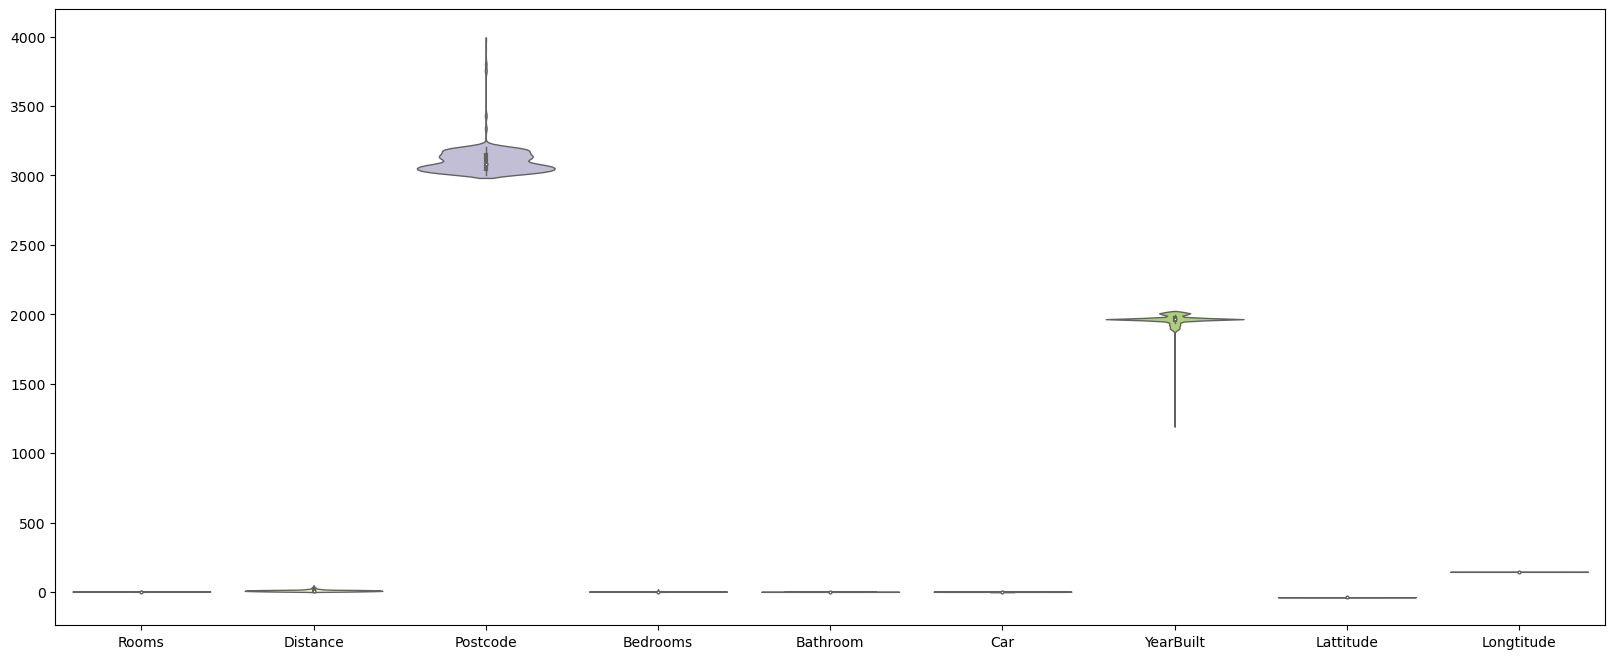

In [25]:
violin2_df = imputed_df[['Rooms', 'Distance', 'Postcode', 'Bedrooms', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude']]
f, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=violin2_df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

We see that Postcode have som positive outliers, while YearBuilt have some negative outliers.

Let's have a look at the correlations in the data next.

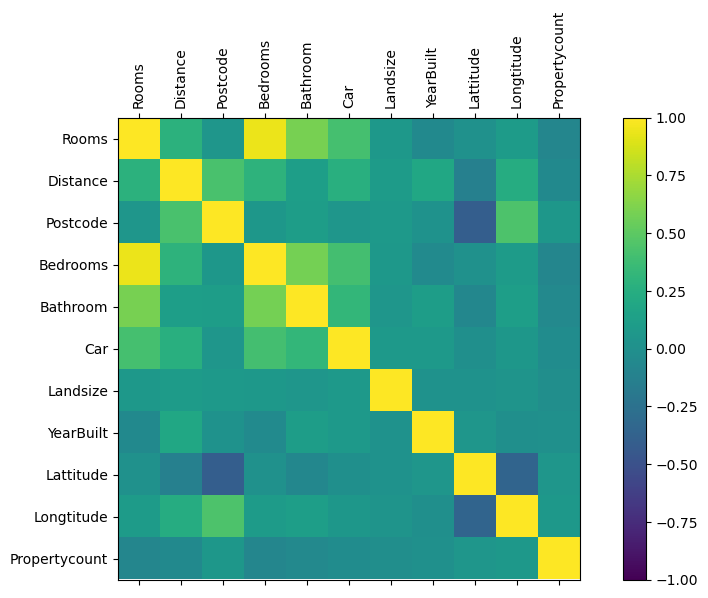

In [26]:
num_vars = imputed_df.iloc[:,:11].shape[1]
correlations = imputed_df.iloc[:,:11].corr()
fig, ax = plt.subplots(figsize=(11, 6))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, num_vars, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(imputed_df.iloc[:,:11].columns[:]), rotation=90)
ax.set_yticklabels(list(imputed_df.iloc[:,:11].columns[:]))
plt.show()

The features with the highest positive correlations are number of bedrooms and number of rooms.  
We also have some negative correlations in the data. Postcode is negatively correlated with the lattitude, and the lattitude is negatively correlated with longitude as well.

### Data cleaning

Removing outliers from landsize using the iqr method.

In [27]:
def outliers(data):
    sorted(data)
    Q1,Q3 = np.percentile(data , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

landsize_lowerbound, landsize_upperbound = outliers(imputed_df['Landsize'])

In [28]:
no_outliers_df = imputed_df.drop(imputed_df[ (imputed_df['Landsize']>landsize_upperbound) | (imputed_df['Landsize']<landsize_lowerbound)].index)

In [29]:
imputed_df.shape[0]

11543

In [30]:
print(f'Removing outliers resulted in loss of {imputed_df.shape[0] - no_outliers_df.shape[0]} observations.')

Removing outliers resulted in loss of 321 observations.


In [31]:
print(f'Removing outliers resulted in loss of {(imputed_df.shape[0] - no_outliers_df.shape[0])/imputed_df.shape[0]*100:.2f} % observations.')

Removing outliers resulted in loss of 2.78 % observations.


In a dataset of over 11500 obervations, losing 321 observations is fine and represents a loss of only 2.78% of the observations.

In [32]:
imputed_df['Landsize'].max()

76000.0

In [33]:
no_outliers_df['Landsize'].max()

1353.0

We see that the max value of landsize was extremely high before removing outliers, compared to after removing outliers.

### Data preprocessing

#### Train test split

In [86]:
X = no_outliers_df.iloc[:, :-1].to_numpy()
y = no_outliers_df.iloc[:, -1].to_numpy()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Scaling

In [88]:
print('The mean of the features are: \n')
print(np.mean(X_train, axis=0))
print('\n####################\n')
print('The standard deviation of the features are: \n')
print(np.std(X_train, axis=0))

The mean of the features are: 

[ 2.95287958e+00  1.01868664e+01  3.10475682e+03  2.93015484e+00
  1.53111340e+00  1.61574929e+00  4.16495400e+02  1.96446271e+03
 -3.78090089e+01  1.44995617e+02  7.43402079e+03  7.07697449e-01
  8.33240504e-02  2.08978501e-01  1.16854183e-01  6.64810070e-01
  7.90910104e-03  1.22423972e-01  8.80026735e-02  1.09724852e-01
  3.56466526e-03  2.86398574e-01  2.67349894e-03  3.31959452e-02
  3.44881363e-01  2.16553414e-01  3.00768631e-03]

####################

The standard deviation of the features are: 

[9.42189273e-01 5.73659556e+00 8.89844803e+01 9.60580236e-01
 6.81749865e-01 9.53321953e-01 2.87159028e+02 2.91468895e+01
 7.87315967e-02 1.04001797e-01 4.35032038e+03 4.54820591e-01
 2.76371404e-01 4.06579004e-01 3.21246452e-01 4.72056819e-01
 8.85807381e-02 3.27774836e-01 2.83298787e-01 3.12546491e-01
 5.95983088e-02 4.52077904e-01 5.16367248e-02 1.79147912e-01
 4.75329579e-01 4.11895658e-01 5.47598405e-02]


We observe that the mean is practically 0 in the features, but the standard deviation is not close to 1, so the data does not have a standard normal distribution. Let's scale the data.

In [89]:
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [90]:
print(np.mean(X_train_scaled, axis=0))
print(np.std(X_train_scaled, axis=0))

[ 4.10746654e-16  2.83199441e-14  1.76298766e-15 -2.12224876e-17
 -1.44354965e-15  2.42582556e-15 -5.32052463e-16 -1.37927037e-12
 -6.27666621e-13 -2.13719170e-12 -5.56978992e-16 -4.66251621e-16
 -9.39428996e-17 -1.03002033e-15 -5.16055209e-16  6.08081159e-16
 -9.97110629e-16 -1.41785016e-15  3.63453651e-16 -1.56230159e-15
 -5.00548014e-16  8.27503872e-16 -3.90157996e-16 -3.12376219e-16
  6.49635680e-16 -1.07260134e-15  6.15274358e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


We now observe that the mean is practically 0 and the standard deviation is 1, so we now have a standard normal distribution.

### Modelling

Let's first have a look at the principal components.

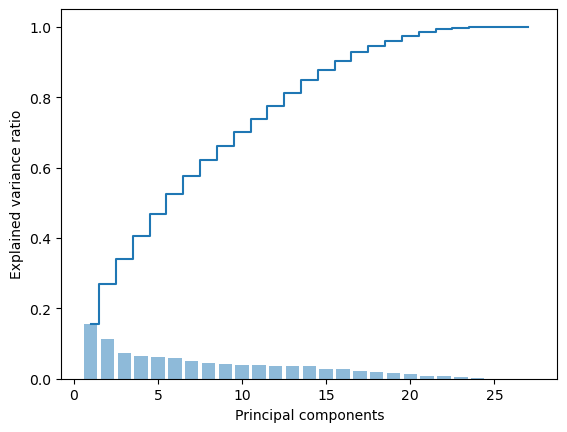

In [91]:
ncomp = 27
pca = PCA(n_components=ncomp)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.bar(range(1, ncomp+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, ncomp+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

At 20 principal components it looks like we have explianed about 90% of the variance, and 25 PCs explain 100% of the variance.

For training the models, we will make a pipeline consiting of PCA and a classifier.  
To optimizing number of PCs and settings in the classifier we will use gridsearch, with 5 folds, to explore some parameterspace for o
We will use macro f1 score as the parameter to optimize the training.

#### Logistic regression

Let's make some pipelines with different classification models.

In [92]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'logisticregression__penalty': [None, 'l1', 'l2', 'elastic'],
    'logisticregression__C': [0.1, 0.5, 1, 1.5, 2, 4, 6, 8, 10, 20, 50, 100, 200],
}

pipe_lr = make_pipeline(PCA(n_components=20), # Compression using PCA
                         LogisticRegression()) # Fit logistic regresion classifier


grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_lr.fit(X_train_scaled, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'pca__n_components': 25}
0.7184460672678871


#### K-nearest neighbor

In [93]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 10],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['minkowski', 'chebyshev'],
}

pipe_knn = make_pipeline(PCA(n_components=20), # Compression using PCA
                         KNeighborsClassifier()) # Fit knn classifier


grid_knn = GridSearchCV(pipe_knn, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_knn.fit(X_train_scaled, y_train)

print(grid_knn.best_params_)
print(grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__weights': 'distance', 'pca__n_components': 25}
0.6927441525679139


#### Decision tree

In [94]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'decisiontreeclassifier__criterion':['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10, 12],
}

pipe_dt = make_pipeline(PCA(), # Compression using PCA
                        DecisionTreeClassifier()) # Fit decision tree classifier


grid_dt = GridSearchCV(pipe_dt, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_dt.fit(X_train_scaled, y_train)

print(grid_dt.best_params_)
print(grid_dt.best_score_)

best_knn = grid_dt.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'pca__n_components': 25}
0.7114641018327642


#### Random forest

In [95]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'randomforestclassifier__n_estimators': [10, 100, 200, 500],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [2, 4, 6, 8, 10, 12],
}

pipe_rf = make_pipeline(PCA(), # Compression using PCA
                        RandomForestClassifier()) # Fit random forest classifier


grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_rf.fit(X_train_scaled, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'pca__n_components': 25, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 500}
0.7319572428467624


#### Support vector classifier

In [96]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'svc__kernel':['linear', 'rbf'],
    'svc__C': [1, 10, 100],
    'svc__gamma': [1, 0.1, 0.001]
}

pipe_svc = make_pipeline(PCA(), # Compression using PCA
                        SVC()) # Fit support vector classifier


grid_svc = GridSearchCV(pipe_svc, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_svc.fit(X_train_scaled, y_train)

print(grid_svc.best_params_)
print(grid_svc.best_score_)

best_svc = grid_svc.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'pca__n_components': 25, 'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.7541258897908948


We see that the classifier that performed the best in terms of macro f1 is support vector classifier, with a macro f1 score of 0.75.  
Let's try to make a pipeline with random forest using kernel PCA, which will allow us to do PCA on nonlinear data, and see if we can get a higher f1 score. We will also try to increase the depth of the trees and the number of trees in the forest.

#### Random forest classifier with kernel PCA

In [38]:
param_grid = {
    'kernelpca__n_components': [20, 25],
    'kernelpca__kernel': ['poly', 'rbf'],
    'randomforestclassifier__n_estimators': [100, 500, 1000],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [10, 15, 20],
}

pipe_kernelrf = make_pipeline(KernelPCA(), # Compression using kernel PCA
                        RandomForestClassifier()) # Fit support vector classifier


grid_kernelrf = GridSearchCV(pipe_kernelrf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_kernelrf.fit(X_train_scaled, y_train)

print(grid_kernelrf.best_params_)
print(grid_kernelrf.best_score_)

best_kernelrf = grid_kernelrf.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'kernelpca__kernel': 'poly', 'kernelpca__n_components': 20, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 500}
0.7322044123152935


Training the random forest classifer using kernel PCA lead to an incremental increase in macro f1 score, compared to random forest together with linear pca. Increasing the depth of the trees and the number of trees did not provide better results. 

Thus, our best performing model is support vector classifier using linear PCA.  
The set of parameters that got the best performance out of the PCA and SVC pipeline was:  
Number of PCs: 25,  
Regularization: 10,  
Kernel: rbf,  

These parameters gave us a macro f1 score of:  
0.7541

#### Cofusion matrix

Let's use K-fold cross-validation to make a confusion matrix for the support vector classifier using the optimal parameters.

In [40]:
# We use 5 folds, fit a model and make a prediction for each fold
kfold = KFold(n_splits=5)

predicted_targets = np.array([]) # Array for predictions
actual_targets = np.array([]) # Array for true y values

pipe_svc = make_pipeline(PCA(n_components=25), SVC(C=10, gamma=0.1, kernel='rbf'))


for i in kfold.split(no_outliers_df):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
    pipe_svc.fit(X_train, y_train)
    y_pred = pipe_svc.predict(X_test)
    predicted_targets= np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)

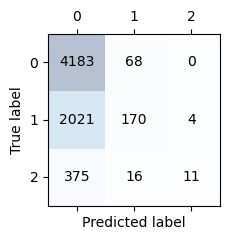

In [43]:
# Make confusion matrix
confmat = confusion_matrix(y_true=actual_targets, y_pred=predicted_targets)

# Make the plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

From the confusion matrix we see that we predict a lot of prices to belong to class 0, while they actually belong to class 1. We have also wronly predicted a lot of the observations belonging in class 2 as belonging in class 0.  
Roughly we have misclassified at least 1/3 of the observations.  
This has given us reason to believe that we lost some important information when cleaning the data.

Let's retrain the models using the imputed_df dataset, where the outliers are still in the dataset, and see if we can get better results.

#### Train test split

In [97]:
X = imputed_df.iloc[:, :-1].to_numpy()
y = imputed_df.iloc[:, -1].to_numpy()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Scaling

In [99]:
print('The mean of the features are: \n')
print(np.mean(X_train, axis=0))
print('\n####################\n')
print('The standard deviation of the features are: \n')
print(np.std(X_train, axis=0))

The mean of the features are: 

[ 2.94628547e+00  1.01073966e+01  3.10530117e+03  2.92473468e+00
  1.53603362e+00  1.61683024e+00  5.20521315e+02  1.96463176e+03
 -3.78094426e+01  1.44994198e+02  7.43009970e+03  6.94390297e-01
  8.21962313e-02  2.23413472e-01  1.17825428e-01  6.62226554e-01
  7.25579381e-03  1.24214858e-01  8.84773663e-02  1.05371453e-01
  3.68204462e-03  2.86224821e-01  2.81568118e-03  3.16222655e-02
  3.48061512e-01  2.19623132e-01  2.59909032e-03]

####################

The standard deviation of the features are: 

[9.52827012e-01 5.81705912e+00 9.04022821e+01 9.51993144e-01
 6.91215018e-01 9.49933212e-01 1.35836218e+03 2.93213912e+01
 7.90669941e-02 1.03386908e-01 4.33238629e+03 4.60665185e-01
 2.74663450e-01 4.16533183e-01 3.22401297e-01 4.72950891e-01
 8.48713571e-02 3.29826511e-01 2.83987890e-01 3.07031448e-01
 6.05680375e-02 4.51995767e-01 5.29882357e-02 1.74992279e-01
 4.76355640e-01 4.13991319e-01 5.09149786e-02]


We need to scale the data.

In [100]:
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [101]:
print(np.mean(X_train_scaled, axis=0))
print(np.std(X_train_scaled, axis=0))

[-1.15345848e-15  2.76084085e-14 -1.81537215e-15  4.00661383e-16
 -1.30091110e-16  1.33048819e-15 -1.55536351e-16 -6.30432517e-13
  1.39006232e-12 -1.11810902e-12 -1.58647601e-15 -7.47025958e-16
 -7.51258127e-16  3.43190449e-16  3.03694210e-16  8.85389035e-17
 -5.44978954e-16  3.83720683e-16 -2.54050385e-16 -7.88842675e-17
  8.27196709e-16  7.39836080e-16  3.55345912e-16  7.57504184e-16
 -8.64949582e-17  3.12050340e-16  1.21033126e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


### Modelling

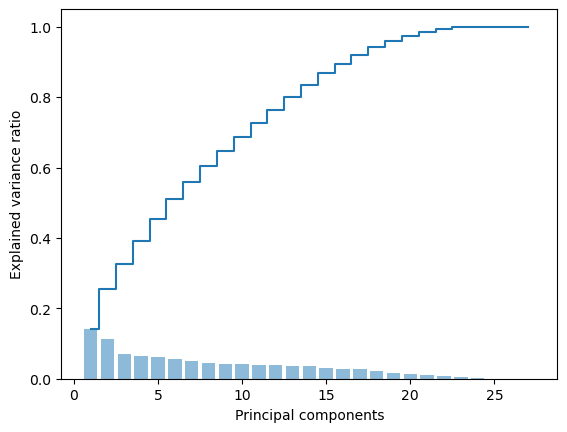

In [43]:
ncomp = 27
pca = PCA(n_components=ncomp)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.bar(range(1, ncomp+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, ncomp+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

#### Logistic regression

In [102]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'logisticregression__penalty': [None, 'l1', 'l2', 'elastic'],
    'logisticregression__C': [1, 10, 50, 100, 200],
}

pipe_lr = make_pipeline(PCA(), # Compression using PCA
                         LogisticRegression()) # Fit logistic regresion classifier


grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_lr.fit(X_train_scaled, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'logisticregression__C': 200, 'logisticregression__penalty': 'l2', 'pca__n_components': 20}
0.8101586655412044


#### Support vector classifier

In [107]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'svc__kernel':['linear', 'rbf'],
    'svc__C': [1, 10, 100],
    'svc__gamma': [1, 0.1, 0.001]
}

pipe_svc = make_pipeline(PCA(), # Compression using PCA
                        SVC()) # Fit support vector classifier


grid_svc = GridSearchCV(pipe_svc, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="f1_macro")

grid_svc.fit(X_train_scaled, y_train)

print(grid_svc.best_params_)
print(grid_svc.best_score_)

best_svc = grid_svc.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'pca__n_components': 15, 'svc__C': 100, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.7411941396098074


#### K-nearest neighbor

In [104]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 10],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['minkowski', 'chebyshev'],
}

pipe_knn = make_pipeline(PCA(n_components=20), # Compression using PCA
                         KNeighborsClassifier()) # Fit knn classifier


grid_knn = GridSearchCV(pipe_knn, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_knn.fit(X_train_scaled, y_train)

print(grid_knn.best_params_)
print(grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance', 'pca__n_components': 15}
0.8085334714546912


#### Decision tree

In [105]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'decisiontreeclassifier__criterion':['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10, 12],
}

pipe_dt = make_pipeline(PCA(), # Compression using PCA
                        DecisionTreeClassifier()) # Fit decision tree classifier


grid_dt = GridSearchCV(pipe_dt, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_dt.fit(X_train_scaled, y_train)

print(grid_dt.best_params_)
print(grid_dt.best_score_)

best_knn = grid_dt.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8, 'pca__n_components': 25}
0.7890385333951986


#### Random forest

In [106]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'randomforestclassifier__n_estimators': [10, 100, 200, 500],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [2, 4, 6, 8, 10, 12],
}

pipe_rf = make_pipeline(PCA(), # Compression using PCA
                        RandomForestClassifier()) # Fit random forest classifier


grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_rf.fit(X_train_scaled, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'pca__n_components': 25, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200}
0.8353899415819391


Looks like the macro f1 score is decreasing for all models when using the dataset containing the outliers. Let's have a look at a confusion matrix to see what's going on.

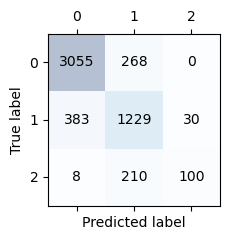

In [48]:
# Make confusion matrix
confmat = confusion_matrix(y_true=actual_targets, y_pred=predicted_targets)

# Make the plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

From the confusion matrix we see that we make less errors when using the dataset containing the outliers, even though the macro f1 score is lower. Let's try using a different scoring metric than macro f1 and see if we get even better results.

In [53]:
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6222627737226277

We got an accuracy of 0.62 using random forest trained using macro f1. Let's use accuracy for training.

#### Logistic regression

In [72]:
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'logisticregression__penalty': [None, 'l1', 'l2', 'elastic'],
    'logisticregression__C': [0.1, 0.5, 1, 1.5, 2, 4, 6, 8, 10, 20, 50, 100, 200],
}

pipe_lr = make_pipeline(PCA(), # Compression using PCA
                         LogisticRegression()) # Fit logistic regresion classifier


grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_lr.fit(X_train_scaled, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'pca__n_components': 25}
0.8237701856803421


#### Support vector machines

In [91]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'svc__kernel':['linear', 'rbf'],
    'svc__C': [1, 10, 100],
    'svc__gamma': [1, 0.1, 0.001]
}

pipe_svc = make_pipeline(PCA(), # Compression using PCA
                        SVC()) # Fit support vector classifier


grid_svc = GridSearchCV(pipe_svc, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_svc.fit(X_train_scaled, y_train)

print(grid_svc.best_params_)
print(grid_svc.best_score_)

best_svc = grid_svc.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'pca__n_components': 25, 'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.8370273774590393


#### KNN

In [92]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 10],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['minkowski', 'chebyshev'],
}

pipe_knn = make_pipeline(PCA(n_components=20), # Compression using PCA
                         KNeighborsClassifier()) # Fit knn classifier


grid_knn = GridSearchCV(pipe_knn, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_knn.fit(X_train_scaled, y_train)

print(grid_knn.best_params_)
print(grid_knn.best_score_)

best_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance', 'pca__n_components': 25}
0.8047232165567557


#### Decision tree

In [93]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'decisiontreeclassifier__criterion':['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [2, 5, 10, 12],
}

pipe_dt = make_pipeline(PCA(), # Compression using PCA
                        DecisionTreeClassifier()) # Fit decision tree classifier


grid_dt = GridSearchCV(pipe_dt, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_dt.fit(X_train_scaled, y_train)

print(grid_dt.best_params_)
print(grid_dt.best_score_)

best_knn = grid_dt.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'pca__n_components': 25}
0.7948098218883188


#### Random forest

In [94]:
param_grid = {
    'pca__n_components': [15, 20, 25],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [10, 12, 15, 20],
}

pipe_rf = make_pipeline(PCA(), # Compression using PCA
                        RandomForestClassifier()) # Fit random forest classifier


grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="accuracy")

grid_rf.fit(X_train_scaled, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'pca__n_components': 25, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 200}
0.8428215595163501


#### Confusion matrix

In [95]:
# We use 5 folds, fit a model and make a prediction for each fold
kfold = KFold(n_splits=5)

predicted_targets = np.array([]) # Array for predictions
actual_targets = np.array([]) # Array for true y values

pipe_rf = make_pipeline(PCA(n_components=25), RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=200))

for i in kfold.split(no_outliers_df):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
    pipe_rf.fit(X_train, y_train)
    y_pred = pipe_rf.predict(X_test)
    predicted_targets= np.append(predicted_targets, y_pred)
    actual_targets = np.append(actual_targets, y_test)

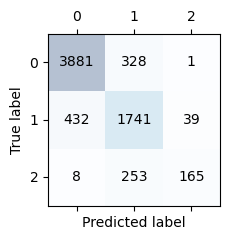

In [96]:
# Make confusion matrix
confmat = confusion_matrix(y_true=actual_targets, y_pred=predicted_targets)

# Make the plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()